<a href="https://colab.research.google.com/github/a123700/Leo/blob/master/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cycle Generative Adversarial Network

### Setup

In [1]:
api_token = {"username":"srhgccc","key":"41c36ccc1ee7bc07f70e459ccbf7df7c"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')

In [2]:
!kaggle competitions download -c gan-getting-started

 97% 355M/367M [00:01<00:00, 225MB/s]
100% 367M/367M [00:01<00:00, 235MB/s]


In [3]:
!unzip gan-getting-started.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391d94b.jpg  
  inflating: photo_jpg/47df262cc5.jpg  
  inflating: photo_

In [4]:
# To generate GIFs
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00


In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow_addons.layers import InstanceNormalization

import time

import matplotlib.pyplot as plt
import cv2
import concurrent.futures

import warnings
warnings.filterwarnings('ignore')

import math
import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tqdm import tqdm

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from IPython.display import clear_output

### Load and prepare the dataset

In [6]:
train_A_paths = glob.glob('photo_jpg/*.jpg')
train_B_paths = glob.glob('monet_jpg/*.jpg')
print(len(train_A_paths))
print(len(train_B_paths))

# test_A_paths = glob.glob('testA/*.jpg')
# test_B_paths = glob.glob('testB/*.jpg')
# print(len(train_A_paths))
# print(len(train_B_paths))

7038
300


In [7]:
def read_img(image):
    img = tf.keras.preprocessing.image.load_img(image, color_mode='rgb', target_size=(img_size, img_size))
    return img
def prepare_dataset(namelist):
    start = time.time()
    imgs = []
    with concurrent.futures.ThreadPoolExecutor(max_workers = 16) as executor:
        i = 0
        for value in executor.map(read_img, namelist):
            i+=1
            print("\rFetching: [{}/{}]".format(i, len(namelist)), end="", flush=True)
            imgs.append(value)
        imgs = np.stack(imgs)
        imgs = tf.convert_to_tensor(imgs)
    print("\nExecution time: ",round(time.time() - start), "s")
    return imgs

In [8]:
img_size = 128
channels = 3

images=prepare_dataset(train_A_paths)
images_trans=prepare_dataset(train_B_paths)

# images_test=prepare_dataset(test_A_paths)
# images_trans_test=prepare_dataset(test_B_paths)

Fetching: [7038/7038]
Execution time:  55 s
Fetching: [300/300]
Execution time:  1 s


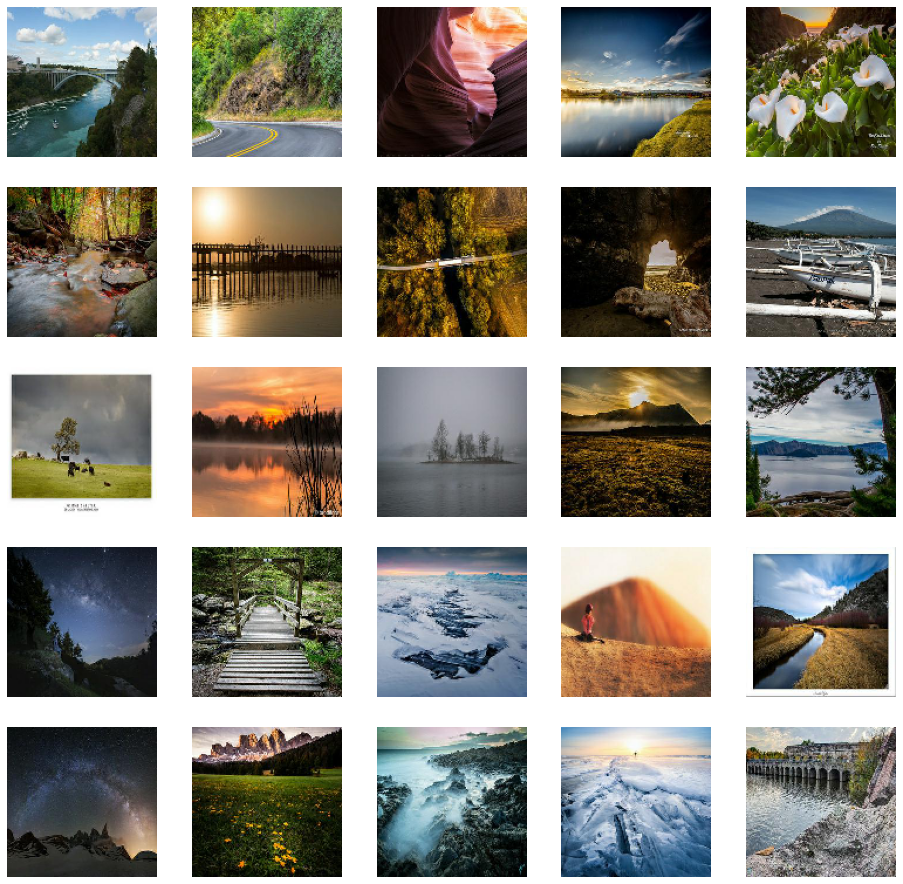

In [9]:
_,ax = plt.subplots(5,5, figsize = (16, 16)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

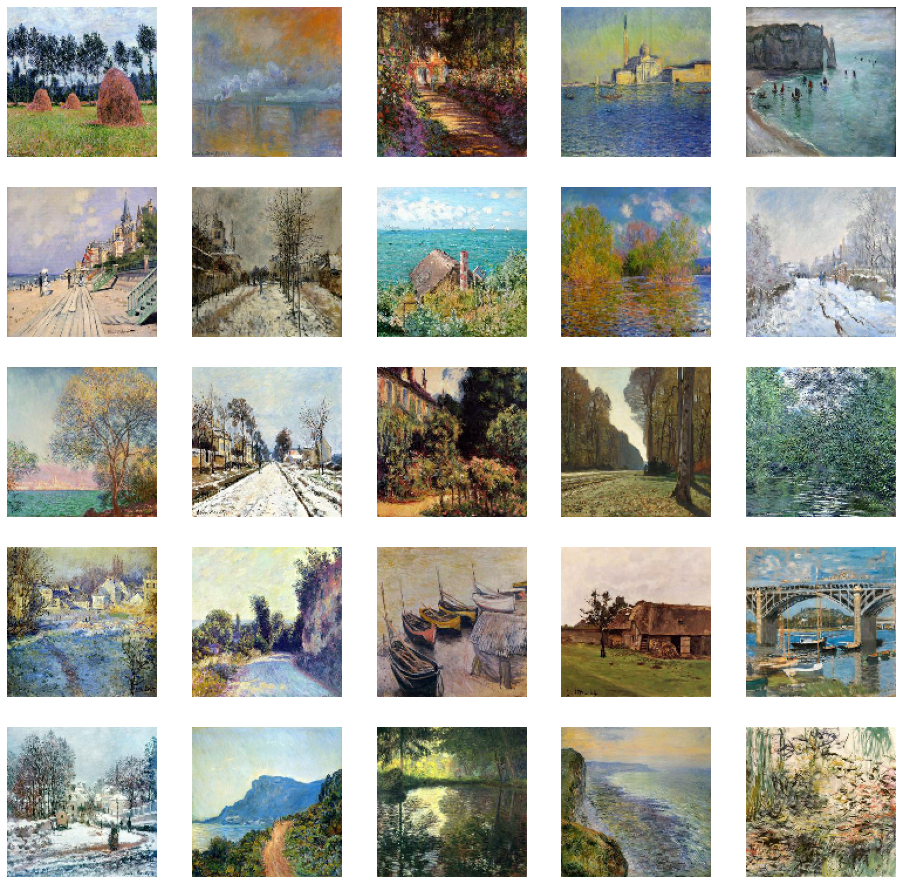

In [10]:
_,ax = plt.subplots(5,5, figsize = (16, 16)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images_trans[5*i+j])
        ax[i,j].axis('off')

In [11]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

train_images = images.reshape(-1, img_size, img_size, channels).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_trans_images = images_trans.reshape(-1, img_size, img_size, channels).astype('float32')
train_trans_images = (train_trans_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# test_images = images_test.reshape(-1, img_size, img_size, channels).astype('float32')
# test_images = (test_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# test_trans_images = images_trans_test.reshape(-1, img_size, img_size, channels).astype('float32')
# test_trans_images = (train_trans_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

## Hyperparameter

In [12]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

img_shape = (img_size, img_size, channels)

In [13]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
train_trans_dataset = tf.data.Dataset.from_tensor_slices(train_trans_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

## Create the models


### The Generator

In [14]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [15]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [16]:
def make_generator_model():
    inputs = layers.Input(shape=[img_size,img_size,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(channels, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    ind = int(math.log2(img_size))
    for i in range(ind):
        x = down_stack[i](x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
      try:
        x = up(x)
        x = layers.Concatenate()([x, skip])
      except:
        continue

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [17]:
generator = make_generator_model()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 64)   3072        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 128)  131328      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 16, 256)  524800      ['sequential_1[0][0]']       

Use the (as yet untrained) generator to create an image.

In [18]:
import random

rand = random.randrange(train_images.shape[0] - 16)
example_image = np.reshape(train_images[rand:rand+16], (-1, img_size, img_size, channels))
generated_image = generator(example_image, training=False)
cycle_image = generator(generated_image, training=False)

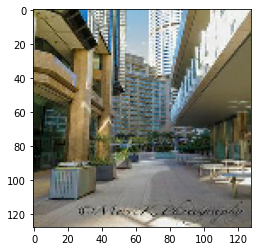

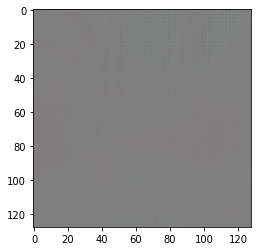

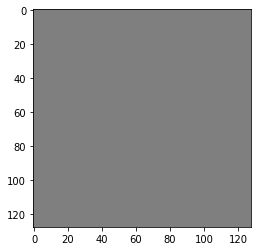

In [19]:
plt.imshow((example_image[0, :, :, :]*127.5+127.5).astype(np.uint8))
plt.show()

plt.imshow((generated_image[0, :, :, :]*127.5+127.5).astype(np.uint8))
plt.show()

plt.imshow((cycle_image[0, :, :, :]*127.5+127.5).astype(np.uint8))
plt.show()

### The Discriminator


In [20]:
def make_discriminator_model():
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  input = Input(shape=img_shape, name='input_image')
  x = downsample(64, 4, False)(input) # (bs, 128, 128, 64)
  x = downsample(128, 4)(x) # (bs, 64, 64, 128)
  x = downsample(256, 4)(x) # (bs, 32, 32, 256)

  x = layers.ZeroPadding2D()(x) # (bs, 34, 34, 256)
  x = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(x) # (bs, 31, 31, 512)
  x = InstanceNormalization(gamma_initializer=gamma_init)(x)
  x = layers.LeakyReLU()(x)
  x = layers.ZeroPadding2D()(x) # (bs, 33, 33, 512)
  x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x) # (bs, 30, 30, 1)
  x = layers.Flatten()(x)

  input1 = Input(shape=img_shape, name='input_image1')
  y = downsample(64, 4, False)(input1) # (bs, 128, 128, 64)
  y = downsample(128, 4)(y) # (bs, 64, 64, 128)
  y = downsample(256, 4)(y) # (bs, 32, 32, 256)

  y = layers.ZeroPadding2D()(y) # (bs, 34, 34, 256)
  y = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(y) # (bs, 31, 31, 512)
  y = InstanceNormalization(gamma_initializer=gamma_init)(y)
  y = layers.LeakyReLU()(y)
  y = layers.ZeroPadding2D()(y) # (bs, 33, 33, 512)
  y = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(y) # (bs, 30, 30, 1)
  y = layers.Flatten()(y)
    
  z = layers.Multiply()([x, y])
  z = Dense(units=1, activation=None)(z) 
    
  model = Model([input, input1], z)
  model.summary()
  return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [21]:
discriminator = make_discriminator_model()
target_image = np.reshape(train_trans_images[0], (-1, img_size, img_size, channels))
generated_image = np.reshape(generated_image[0], (-1, img_size, img_size, channels))

decision = discriminator([generated_image, target_image])
print(decision)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_image1 (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_15 (Sequential)     (None, 64, 64, 64)   3072        ['input_image[0][0]']            
                                                                                            

## Define the loss and optimizers


In [22]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss


In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [24]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [25]:
def cycle_loss(A2B, B2A):
  loss_fn = tf.keras.losses.MeanSquaredError()
  return loss_fn(A2B, B2A)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [26]:
A2B_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
B2A_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Define the training loop


In [27]:
A2B_gen = make_generator_model()
B2A_gen = make_generator_model()

cycle_input = Input(shape=img_shape)
A2B = A2B_gen(cycle_input)
B2A = B2A_gen(A2B)
cycle_model = Model(cycle_input, B2A)

In [32]:
@tf.function
def train_step(images, target_images, gp_weight=10.0):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as cycle_tape:
      A2B_images = A2B_gen(images, training=True)
      B2A_images = B2A_gen(A2B_images, training=True)

      real_output = discriminator([images, images], training=True)
      fake_output = discriminator([images, B2A_images], training=True)

      gen_loss = generator_loss(fake_output)
      cycled_loss = cycle_loss(images, B2A_images)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, A2B_gen.trainable_variables)
    gradients_of_cycle_A2B = cycle_tape.gradient(cycled_loss, cycle_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    A2B_generator_optimizer.apply_gradients(zip(gradients_of_generator, A2B_gen.trainable_variables))
    B2A_generator_optimizer.apply_gradients(zip(gradients_of_cycle_A2B, cycle_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [33]:
def train(dataset, target_dataset, epochs):
  for epoch in range(epochs):
    rand = random.randrange(train_images.shape[0]-16)
    seed = np.reshape(train_images[rand:rand+16], (-1, img_size, img_size, channels))
    start = time.time()

    for image_batch, target_batch in tf.data.Dataset.zip((dataset, target_dataset)):
      train_step(image_batch, target_batch)

    # Produce images for the GIF as you go
    clear_output(wait=True)
    generate_and_save_images(A2B_gen,
                             epoch + 1,
                             seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, round(time.time()-start)))

  # Generate after the final epoch
  clear_output(wait=True)
  generate_and_save_images(A2B_gen,
                           epochs,
                           seed)

**Generate and save images**


In [34]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(16, 16))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :]*127.5+127.5).astype(np.uint8))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

In [ ]:
EPOCHS = 1000
train(train_dataset, train_trans_dataset, EPOCHS)

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)